  0%|          | 0/5060 [00:00<?, ?it/s]

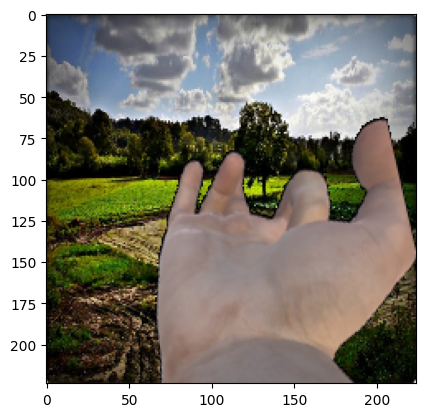

In [2]:
import sys
from matplotlib import pyplot as plt
sys.path.append(os.path.abspath('../..'))
from tqdm import tqdm
from src.utils.miscellaneous import mkdir
import os
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import cv2
from torch.utils.data import random_split, ConcatDataset
import random
import os.path as op
import torch
import math
import json
import pickle


class Pkl_transform(Dataset):
    def __init__(self, phase):
        self.phase = phase
        self.root = "../../datasets/Armo"
        self.folder_num = os.listdir(
            self.root + "/annotations/train/wrist_angles")
        self.dict = dict()

    def set_path(self, num):
        if self.phase != "train":
            with open(os.path.join(self.root, f"annotations/{self.phase}/CISLAB_{self.phase}_camera.json"), "r") as st_json:
                self.camera = json.load(st_json)
            with open(os.path.join(self.root, f"annotations/{self.phase}/CISLAB_{self.phase}_joint_3d.json"), "r") as st_json:
                self.joint = json.load(st_json)
            with open(os.path.join(self.root, f"annotations/{self.phase}/CISLAB_{self.phase}_data.json"), "r") as st_json:
                self.meta = json.load(st_json)
            self.img_root = os.path.join(self.root, f"images/{self.phase}")    
            
        else:
            with open(os.path.join(self.root, f"annotations/train/wrist_angles/{num}/CISLAB_train_camera.json"), "r") as st_json:
                self.camera = json.load(st_json)
            with open(os.path.join(self.root, f"annotations/train/wrist_angles/{num}/CISLAB_train_joint_3d.json"), "r") as st_json:
                self.joint = json.load(st_json)
            with open(os.path.join(self.root, f"annotations/train/wrist_angles/{num}/CISLAB_train_data.json"), "r") as st_json:
                self.meta = json.load(st_json)
            self.img_root = os.path.join(self.root, f"images/train/wrist_angles/{num}")
        
        self.store_path = os.path.join(
            self.root, f"annotations/{self.phase}/revision_data.pkl")

    def processing(self, num, img_store = False):
        self.set_path(num)

        pbar = tqdm(total=len(self.meta['images']))
        self.dict["%s" % num] = list()

        for idx, j in enumerate(self.meta['images']):
            pbar.update(1)
            if j['camera'] == '0':
                continue

            camera = self.meta['images'][idx]['camera']
            id = self.meta['images'][idx]['frame_idx']

            joint_3d = torch.tensor(
                self.joint['0'][f'{id}']['world_coord'][:21])
            focal_length = torch.tensor(
                self.camera['0']['focal'][f'{camera}'][0])
            translation = torch.tensor(self.camera['0']['campos'][f'{camera}'])
            rot = torch.tensor(self.camera['0']['camrot'][f'{camera}'])

            calibrationed_joint = torch.einsum(
                'ij, kj -> ki', rot, (joint_3d - translation))
            calibrationed_joint[:, :2] = calibrationed_joint[:,
                                                             :2]/(calibrationed_joint[:, 2][:, None].repeat(1, 2))
            calibrationed_joint = calibrationed_joint[:,
                                                      :2] * focal_length + 112

            if any(joint[idx] < 20 or joint[idx] > 200 for joint in calibrationed_joint for idx in range(2)):
                continue

            degrees = random.uniform(-20, 20)
            rad = math.radians(degrees)
            # If wrist was rotated, it happend black area under rotated wrist
            lowest_wrist_left, lowest_wrist_right = [
                79-112, -112], [174-112, -112]
            rot_lowest_wrist_left = math.cos(
                rad) * lowest_wrist_left[1] - math.sin(rad) * lowest_wrist_left[0] + 112
            rot_lowest_wrist_right = math.cos(
                rad) * lowest_wrist_right[1] - math.sin(rad) * lowest_wrist_right[0] + 112

            if rot_lowest_wrist_left > 0:
                lift_y = rot_lowest_wrist_left

            elif rot_lowest_wrist_right > 0:
                lift_y = rot_lowest_wrist_right

            else:
                lift_y = 0

            translation_y = random.uniform(0, 40)

            calibrationed_joint[:, 0] = math.cos(
                rad) * (calibrationed_joint[:, 0] - 112) + math.sin(rad) * (calibrationed_joint[:, 1] - 112) + 112
            calibrationed_joint[:, 1] = math.cos(rad) * (calibrationed_joint[:, 1] - 112) - math.sin(
                rad) * (calibrationed_joint[:, 0] - 112) + 112 + lift_y + translation_y

            if any(joint[idx] < 20 or joint[idx] > 200 for joint in calibrationed_joint for idx in range(2)):
                continue
            
            if img_store:
                image_path = os.path.join(self.img_root, '/'.join(self.meta['images'][idx]['file_name'].split('/')[1:]))
                
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                rot_image = i_rotate(image, degrees, 0, (lift_y+ translation_y))
                
                bg_path = "../../datasets/Armo/background"
                bg_list = os.listdir(bg_path)
                bg_len = len(bg_list)
                bg_img = cv2.imread(os.path.join(bg_path, bg_list[idx%bg_len]))
                bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
                bg_img = cv2.resize(bg_img, (224, 224))
                
                index = np.where((rot_image[:, :, 0] == 0) & (rot_image[:, :, 1] == 0) & (rot_image[:, :, 2] == 0))
                rot_image[index] = bg_img[index]
                
                img_root_list = self.img_root.split('/')
                img_root_list[3] = "new_Armo"
                img_root = '/'.join(img_root_list)
                new_img_name = os.path.join(img_root, '/'.join(self.meta['images'][idx]['file_name'].split('/')[1:]))
                new_img_fold_path = os.path.join(img_root, '/'.join(self.meta['images'][idx]['file_name'].split('/')[1:-1]))
                
                if not os.path.isdir(new_img_fold_path):
                    mkdir(new_img_fold_path)
                
                cv2.imwrite(new_img_name, rot_image[:, :, (2, 1, 0)])
                plt.imshow(rot_image)
                plt.show()
                print()
                

            else:    
                # visualize(rot_image, calibrationed_joint)
                self.dict["%s" % num].append({'file_name': self.meta['images'][idx]['file_name'], 'joint_2d': calibrationed_joint.tolist(
                ), 'joint_3d': joint_3d.tolist(), 'move': int(lift_y + translation_y), 'degree': int(degrees)})
            
    def get_json(self):
        if self.phase == "train":
            for num in self.folder_num:
                self.processing(num)
        else:
            self.processing(self.phase)

        with open(self.store_path, 'wb') as f:
            pickle.dump(self.dict, f, protocol=pickle.HIGHEST_PROTOCOL)

        print(f"Done ===> {self.store_path}")
        
    def get_image(self):
        if self.phase == "train":
            for num in self.folder_num:
                self.processing(num, img_store = True)
        else:
            self.processing(self.phase, img_store = True)


def main():
    Pkl_transform(phase="train").get_image()
    # Json_e(phase="test").get_json_g()
    print("ENDDDDDD")


if __name__ == '__main__':
    main()

In [ ]:
with open("../../datasets/Armo/annotations/val/revision_data/pkl", "rb") as f:
    data = pickle.load(f)
data

In [1]:
def i_rotate(img, degree, move_x, move_y):
    h, w = img.shape[:-1]

    centerRotatePT = int(w / 2), int(h / 2)
    new_h, new_w = h, w

    rotatefigure = cv2.getRotationMatrix2D(centerRotatePT, degree, 1)
    result = cv2.warpAffine(img, rotatefigure, (new_w, new_h))
    translation = np.float32([[1, 0, move_x], [0, 1, move_y]])
    result = cv2.warpAffine(result, translation, (new_w, new_h))

    return result

def visualize(image, gt_2d_joint):
    image = ((image + abs(image.min())) / (image + abs(image.min())).max()).copy()
    parents = np.array([-1, 0, 1, 2, 3, 0, 5, 6, 7, 0, 9, 10, 11, 0, 13, 14, 15, 0, 17, 18, 19])
    
    for i in range(21):

        cv2.circle(image, (int(gt_2d_joint[i][0]), int(gt_2d_joint[i][1])), 2, [0, 1, 0],
                    thickness=-1)
        if i != 0:
            cv2.line(image, (int(gt_2d_joint[i][0]), int(gt_2d_joint[i][1])),
                        (int(gt_2d_joint[parents[i]][0]), int(gt_2d_joint[parents[i]][1])),
                        [0, 0, 1], 1)

    plt.imshow(image)
    plt.show()
